In [2]:
import pickle
import torch
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
def resize(image, size = (224,224)):
    pil_image = Image.fromarray(image)
    resized_pil_image = pil_image.resize(size, Image.Resampling.BICUBIC)
    resized_image = np.array(resized_pil_image)
    return resized_image

In [4]:
import cv2
import numpy as np

def detect_edges(image, low_threshold=50, high_threshold=150):
    """
    Detect edges in an image using the Canny edge detection algorithm.

    Parameters:
        image (numpy.ndarray): Input image with shape (224, 224, 3).
        low_threshold (int): Lower threshold for the Canny algorithm.
        high_threshold (int): Upper threshold for the Canny algorithm.

    Returns:
        numpy.ndarray: Edge-detected image with shape (224, 224).
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

# Example usage
image = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)  # Example input
edges = detect_edges(image, low_threshold=50, high_threshold=150)

# To visualize the result:
# import matplotlib.pyplot as plt
# plt.imshow(edges, cmap='gray')
# plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def wiener_filter_rgb(noisy_img, original_img):
    """
    Apply Wiener filter to denoise a noisy image given the original clean image, for RGB images.
    
    Args:
    noisy_img (numpy.ndarray): Noisy image (32x32x3).
    original_img (numpy.ndarray): Original clean image (32x32x3).
    
    Returns:
    numpy.ndarray: Denoised RGB image.
    """
    # Ensure images are in float32 for more precision
    noisy_img = noisy_img.astype(np.float32)
    original_img = original_img.astype(np.float32)
    
    # Initialize a denoised image
    denoised_img = np.zeros_like(noisy_img)
    
    # Apply Wiener filter to each channel
    for c in range(3):  # Iterate over the 3 color channels (R, G, B)
        noisy_channel = noisy_img[..., c]
        original_channel = original_img[..., c]
        
        # Perform FFT on the channel
        noisy_fft = np.fft.fft2(noisy_channel)
        original_fft = np.fft.fft2(original_channel)

        # Compute Power Spectral Densities
        S_xx = np.abs(original_fft) ** 2  # Power of the clean image
        S_nn = np.abs(noisy_fft - original_fft) ** 2  # Power of the noise (difference)

        # Compute the Wiener filter
        H = S_xx / (S_xx + S_nn)  # Wiener filter formula

        # Apply Wiener filter in frequency domain
        filtered_fft = H * noisy_fft

        # Inverse FFT to get the denoised channel
        denoised_channel = np.fft.ifft2(filtered_fft).real
        
        # Store the denoised channel
        denoised_img[..., c] = np.clip(denoised_channel, 0, 255)
    
    return denoised_img.astype(np.uint8)

# Assuming noisy_img and original_img are already numpy arrays of shape (32, 32, 3)
# Example: you can replace this with your own NumPy arrays
# noisy_img = data2[0]
# original_img = data1[0]
# # Apply the Wiener filter
# denoised_image = wiener_filter_rgb(noisy_img, original_img)

# # Display results
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 3, 1)
# plt.title("Original Image")
# plt.imshow(original_img.astype(np.uint8))
# plt.subplot(1, 3, 2)
# plt.title("Noisy Image")
# plt.imshow(noisy_img.astype(np.uint8))
# plt.subplot(1, 3, 3)
# plt.title("Denoised Image (Wiener Filter)")
# plt.imshow(denoised_image)
# plt.show()


In [6]:
import cv2
import numpy as np

def sharpen_with_unsharp_mask(image, strength=1.5, blur_radius=3):
    """
    Sharpen an image using unsharp masking.

    Parameters:
        image (numpy.ndarray): Input image.
        strength (float): Sharpening strength factor.
        blur_radius (int): Radius of the Gaussian blur.

    Returns:
        numpy.ndarray: Sharpened image.
    """
    blurred = cv2.GaussianBlur(image, (blur_radius, blur_radius), 0)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened

# # Example usage
# image = cv2.imread('example.jpg')  # Replace with your image
# sharpened_image = sharpen_with_unsharp_mask(image)
# cv2.imwrite('sharpened_example.jpg', sharpened_image)

In [7]:
def sharpen_with_laplacian(image, alpha=1.0):
    """
    Sharpen an image using Laplacian filtering.

    Parameters:
        image (numpy.ndarray): Input image.
        alpha (float): Scaling factor for the Laplacian result.

    Returns:
        numpy.ndarray: Sharpened image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    sharpened = cv2.convertScaleAbs(gray - alpha * laplacian)
    return cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)

In [8]:
def sharpen_with_high_pass_filter(image, blur_radius=3):
    """
    Sharpen an image using high-pass filtering.

    Parameters:
        image (numpy.ndarray): Input image.
        blur_radius (int): Radius of the Gaussian blur.

    Returns:
        numpy.ndarray: Sharpened image.
    """
    blurred = cv2.GaussianBlur(image, (blur_radius, blur_radius), 0)
    high_pass = cv2.subtract(image, blurred)
    sharpened = cv2.add(image, high_pass)
    return sharpened

# sharpened_image = sharpen_with_high_pass_filter(image)


In [9]:
sharpening_kernel = np.array([[0, -1,  0],
                               [-1,  5, -1],
                               [0, -1,  0]], dtype=np.float32)

def sharpen_with_kernel(image, kernel):
    """
    Sharpen an image using a custom convolution kernel.

    Parameters:
        image (numpy.ndarray): Input image.
        kernel (numpy.ndarray): Convolution kernel.

    Returns:
        numpy.ndarray: Sharpened image.
    """
    return cv2.filter2D(image, -1, kernel)

# sharpened_image = sharpen_with_kernel(image, sharpening_kernel)


In [10]:
import cv2
import numpy as np

def detect_color_edges(image, threshold=75):
    """
    Detect edges based on changes in color intensities.

    Parameters:
        image (numpy.ndarray): Input color image (H, W, 3).
        threshold (int): Gradient magnitude threshold for edge detection.

    Returns:
        numpy.ndarray: Binary edge map (H, W).
    """
    # Split image into R, G, B channels
    channels = cv2.split(image)

    # Compute the gradient magnitude for each channel
    gradients = [cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=3)**2 +
                 cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=3)**2
                 for channel in channels]

    # Combine gradients from all channels
    combined_gradient = np.sqrt(sum(gradients))

    # Normalize and threshold the gradient magnitude
    normalized_gradient = (combined_gradient / combined_gradient.max() * 255).astype(np.uint8)
    edges = (normalized_gradient > threshold).astype(np.uint8) * 255

    return edges

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA

def edge_detection(image):
    """
    Apply Canny edge detection to an image.
    
    Args:
    image (numpy.ndarray): Input image (32x32x3).
    
    Returns:
    numpy.ndarray: Edge-detected image (binary).
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, 100, 200)
    
    return edges

def pca_transform(image, n_components=3):
    """
    Apply PCA to reduce the dimensionality and extract significant features.
    
    Args:
    image (numpy.ndarray): Input image (32x32x3).
    n_components (int): Number of principal components to keep.
    
    Returns:
    numpy.ndarray: Transformed image after PCA.
    """
    # Reshape the image into a 2D array where each pixel is a sample and the color channels are features
    reshaped_image = image.reshape(-1, 3)  # Shape (32*32, 3)
    
    # Apply PCA to the image
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(reshaped_image)
    
    # Reconstruct the image from the principal components (this is a simplified form)
    reconstructed_image = pca.inverse_transform(pca_result)
    
    # Reshape back to the original image shape
    reconstructed_image = reconstructed_image.reshape(image.shape)
    
    return reconstructed_image

def silhouette_from_image(noisy_img):
    """
    Generate a silhouette-like representation of a noisy image using feature transformation.
    
    Args:
    noisy_img (numpy.ndarray): Noisy image (32x32x3).
    
    Returns:
    numpy.ndarray: Binary silhouette of the image.
    """
    # Step 1: Apply edge detection (Canny)
    edges = edge_detection(noisy_img)
    
    # Step 2: Apply PCA for feature transformation and dimensionality reduction
    pca_image = pca_transform(noisy_img)
    
    # Step 3: Convert PCA result to grayscale and apply thresholding to get a silhouette
    gray_pca_image = cv2.cvtColor(np.uint8(pca_image), cv2.COLOR_RGB2GRAY)
    _, silhouette = cv2.threshold(gray_pca_image, 127, 255, cv2.THRESH_BINARY)
    
    # Step 4: Combine edge and silhouette results for better clarity
    combined_silhouette = cv2.bitwise_or(edges, silhouette)
    
    return combined_silhouette

# # Example: Assuming noisy_img is your noisy image (32x32x3)
# # Replace this with your actual noisy image array
# noisy_img = data2[1]

# # Generate silhouette-like image
# silhouette_image = silhouette_from_image(noisy_img)

# # Display the original noisy image and the silhouette
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.title("Noisy Image")
# plt.imshow(noisy_img.astype(np.uint8))

# plt.subplot(1, 2, 2)
# plt.title("Silhouette of Noisy Image")
# plt.imshow(silhouette_image, cmap='gray')
# plt.show()


In [12]:
import cv2
import numpy as np

def normalize_color_intensity(image, target_saturation=0.5, target_brightness=0.5):
    """
    Normalize color intensity by adjusting saturation and brightness.

    Parameters:
        image (numpy.ndarray): Input image in RGB format.
        target_saturation (float): Target saturation level (0 to 1).
        target_brightness (float): Target brightness level (0 to 1).

    Returns:
        numpy.ndarray: Image with normalized color intensity.
    """
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)

    # Normalize the Saturation channel
    hsv_image[:, :, 1] /= 255.0  # Scale to 0-1
    hsv_image[:, :, 1] = hsv_image[:, :, 1] * target_saturation / np.mean(hsv_image[:, :, 1])
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 1) * 255.0

    # Normalize the Value channel (brightness)
    hsv_image[:, :, 2] /= 255.0  # Scale to 0-1
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * target_brightness / np.mean(hsv_image[:, :, 2])
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2], 0, 1) * 255.0

    # Convert back to RGB
    normalized_image = cv2.cvtColor(hsv_image.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return normalized_image

In [13]:
import numpy as np
from scipy.ndimage import median_filter

def apply_median_blur(image, filter_size=15):
    """
    Apply a median filter to an image.

    Parameters:
        image (numpy.ndarray): Input image with shape (224, 224, 3).
        filter_size (int): Size of the median filter (must be an odd integer).

    Returns:
        numpy.ndarray: Image after applying the median filter.
    """
    # Apply the median filter channel-wise
    filtered_image = np.stack([
        median_filter(image[:, :, channel], size=filter_size)
        for channel in range(image.shape[-1])
    ], axis=-1)
    return filtered_image

# Example usage
# image = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)  # Example input
# filtered_image = apply_median_filter(image, filter_size=3)


In [14]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_blur(image, sigma=5):
    """
    Apply a Gaussian blur to an image.

    Parameters:
        image (numpy.ndarray): Input image with shape (224, 224, 3).
        sigma (float): Standard deviation for Gaussian kernel.

    Returns:
        numpy.ndarray: Image after applying the Gaussian blur.
    """
    # Apply the Gaussian filter channel-wise
    blurred_image = np.stack([
        gaussian_filter(image[:, :, channel], sigma=sigma)
        for channel in range(image.shape[-1])
    ], axis=-1)
    return blurred_image

# Example usage
# gaussian_blurred_image = apply_gaussian_blur(image, sigma=2)


In [15]:
import cv2

def apply_avg_blur(image, kernel_size=15):
    """
    Apply an average blur to an image.

    Parameters:
        image (numpy.ndarray): Input image with shape (224, 224, 3).
        kernel_size (int): Size of the averaging kernel (must be an odd integer).

    Returns:
        numpy.ndarray: Image after applying the average blur.
    """
    # Apply the average blur using OpenCV
    blurred_image = cv2.blur(image, (kernel_size, kernel_size))
    return blurred_image

# Example usage
# avg_blurred_image = apply_avg_blur(image, kernel_size=5)


C:\Users\rajud\AppData\Local\Temp\ipykernel_2856\3981529573.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ds = torch.load(f"dataset\\part_two_dataset\\eval_data\\{i}_e

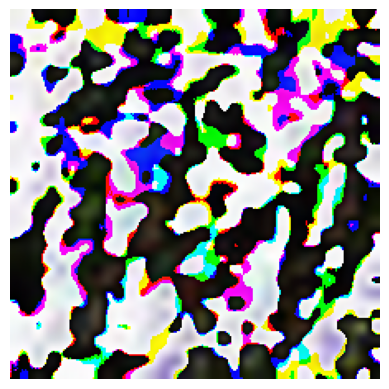

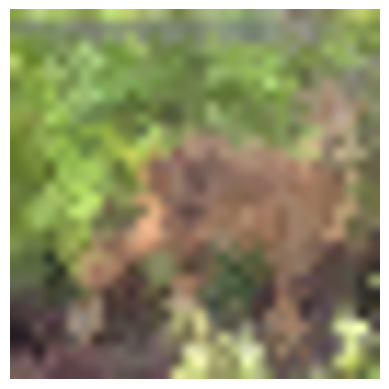

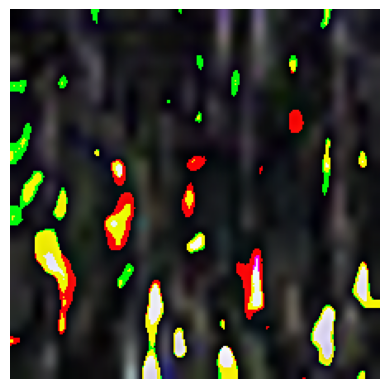

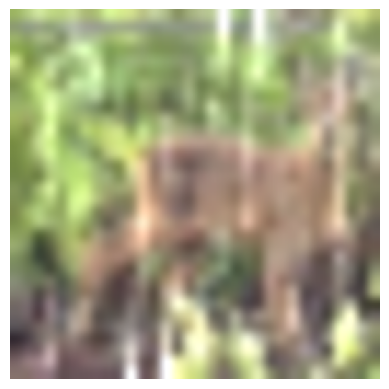

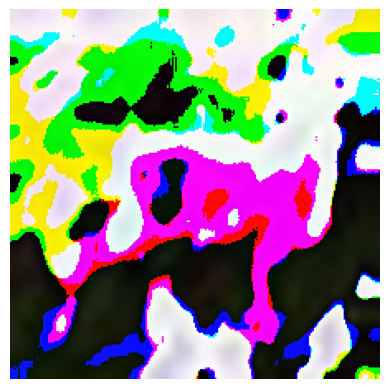

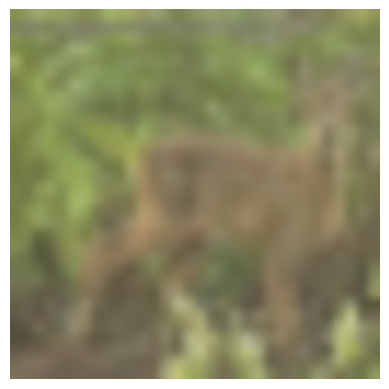

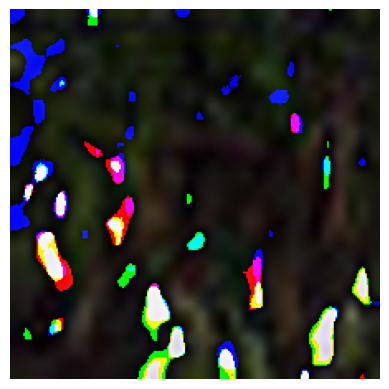

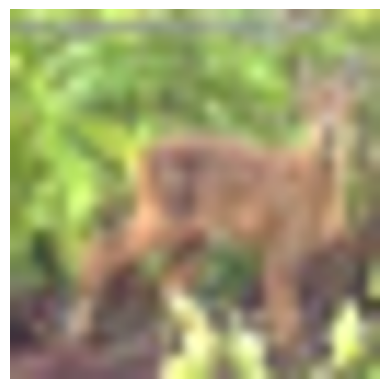

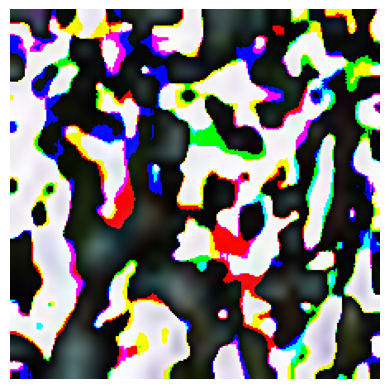

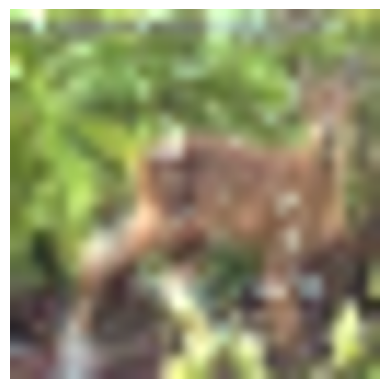

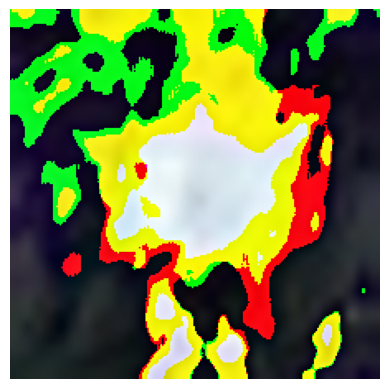

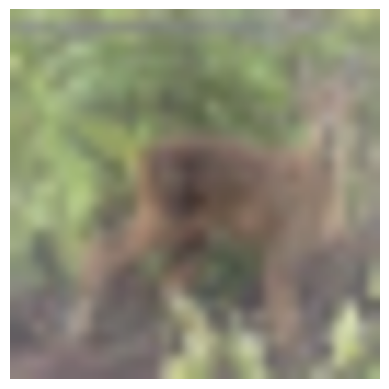

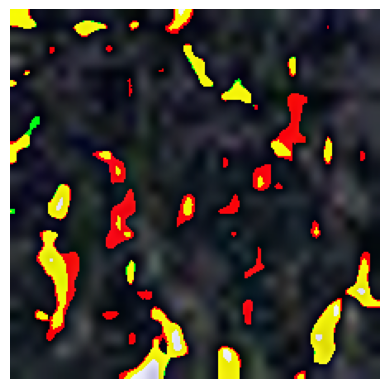

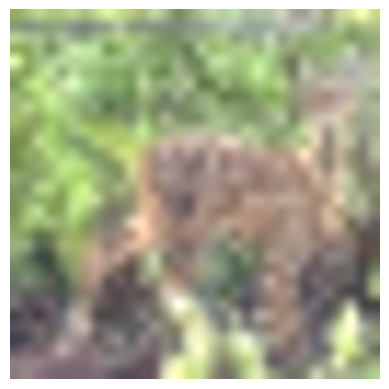

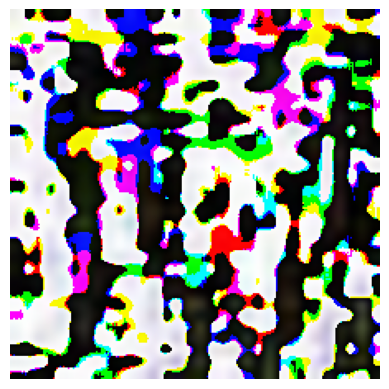

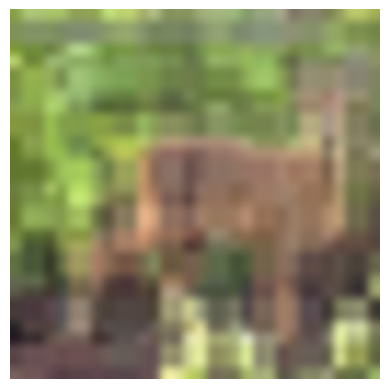

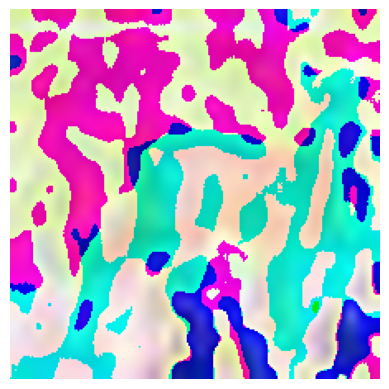

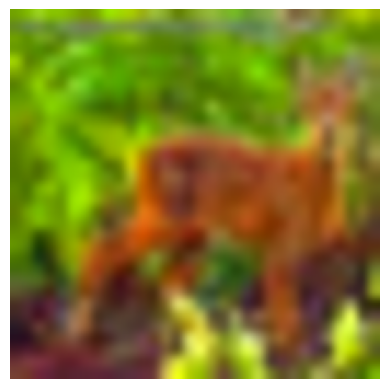

In [20]:
for i in range(2,11):
    ds = torch.load(f"dataset\\part_two_dataset\\eval_data\\{i}_eval_data.tar.pth")
    ds_ = torch.load("dataset\\part_two_dataset\\eval_data\\1_eval_data.tar.pth")
    # print(ds.keys())
    data1 = ds['data']
    data_ = ds_['data']
    modification = resize(data1[0])-resize(data_[0])
    plt.imshow(modification.astype(np.uint8))
    plt.axis('off')
    plt.show()
    plt.imshow(resize(data1[0]))
    plt.axis('off')  # Hide axes for a cleaner view
    plt.show()

In [17]:
eval1 = torch.load("dataset\\part_two_dataset\\eval_data\\1_eval_data.tar.pth");
print(ds1.keys())
data_eval, targets_eval = eval1['data'], eval1['targets']

C:\Users\rajud\AppData\Local\Temp\ipykernel_2856\2912511240.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval1 = torch.load("dataset\\part_two_dataset\\eval_data\\1_e

NameError: name 'ds1' is not defined

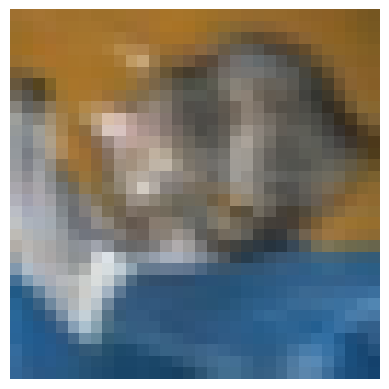

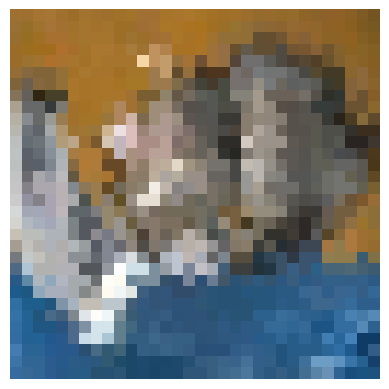

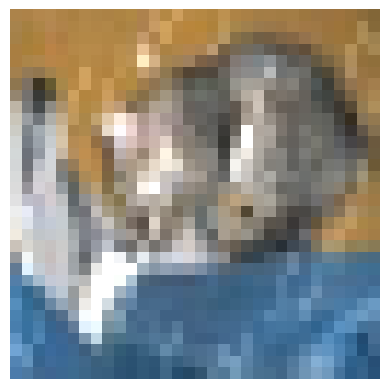

In [ ]:
for i in range(1):    
    plt.imshow(data1[i])
    plt.axis('off')  # Hide axes for a cleaner view
    plt.show()

for i in range(1):    
    plt.imshow(data2[i])
    plt.axis('off')  # Hide axes for a cleaner view
    plt.show()

for i in range(1):    
    plt.imshow(data3[i])
    plt.axis('off')  # Hide axes for a cleaner view
    plt.show()